# Transfer learning for concrete crack detection

## Modified VGG-16 pre-trained model for the cracked vs uncracked dataset

In [1]:
# Import libraries
import matplotlib.pyplot as plt
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from tensorflow.keras.utils import plot_model

Using TensorFlow backend.
C:\Users\TORIT\anaconda3\envs\tensorpower\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\TORIT\anaconda3\envs\tensorpower\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\TORIT\anaconda3\envs\tensorpower\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\TORIT\anaconda3\envs

In [2]:
# Define cnn model
def define_model():
    # load model
    model=model = VGG16(include_top=False, input_shape= (224, 224, 3))
    #mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable= False #Con esto le digo al modelo que no entrene las capas del modelo precargado
    # allow last vgg block as not trainable
    model.get_layer('block5_conv1').trainable = True
    model.get_layer('block5_conv2').trainable = True
    model.get_layer('block5_conv3').trainable = True
    model.get_layer('block5_pool').trainable = True
           
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output) #Flatt th model, except the last hidden
    #class1 = Dropout(0.5)(Class0) 
    class0 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    x = Dropout(0.2)(class0)
    output = Dense(1, activation='sigmoid')(x)
    #define new model
    model=Model(inputs=model.inputs,outputs=output)
    # compile model
    opt = SGD(lr=0.00001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    #plot graph
    MLP=plot_model(model, show_shapes=True, to_file='multilayer_perceptron_graph2.svg'); #We save the model summary in different formats
    MLP=plot_model(model, show_shapes=True, to_file='multilayer_perceptron_graph2.png');        
    return model

In [3]:
# Plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.title('Binary Cross Entropy Loss')
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'k--', label='Training loss')
    plt.plot(epochs, val_loss, 'g--', label='Testing loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('15-loss.pdf')
    plt.show()
    # plot accuracy
    accuracy = history.history['acc']
    val_accuracy = history.history['val_acc']
    epochs = range(len(loss))
    plt.plot(epochs, accuracy, 'k--', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'g--', label='Testing accuracy')
    plt.title('Training and testing Accuracy')
    plt.legend()
    plt.grid()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.savefig('15-accu.pdf')
    plt.show()


In [4]:
# Run the test harness for evaluating a model
def run_test_harness():
    # define model
    model = define_model()
    # create data generator
    train_datagen= ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90) 
    test_datagen= ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for centering
    train_datagen.mean = [123.68, 116.779, 103.939]
    test_datagen.mean = [123.68, 116.779, 103.939]
    # prepare iterators
    train_it = train_datagen.flow_from_directory('dataset/train/', class_mode='binary', batch_size=16, target_size=(224, 224))
    test_it = test_datagen.flow_from_directory('dataset/test/', class_mode='binary', batch_size=16, target_size=(224, 224))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it), validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> %.4f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history)
    #save model
    model.save('crack_classifier_model.h5')
    model.save_weights('crack_classifier_model_weights.h5')
    # entry point, run the test harness


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

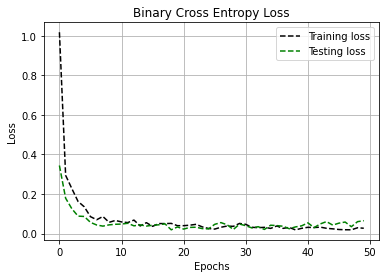

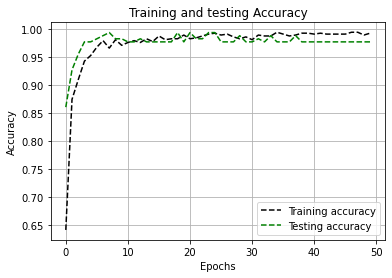

In [5]:
# entry point, run the test harness
run_test_harness()